### Import modules

In [1]:
import networkx as nx

from agents import GUCB_agent
from utils import return_graph,draw_graph
from core import train_agent

import numpy as np
from functools import partial
from time import time

import pickle as pkl

from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

SEED = 181731

In [2]:
from agents import get_ucb
def direct_agent(env):
    ucb = get_ucb(env)
    
    # Determine the destination node.
    dest = np.argmax(ucb)
    
    # Travel to the node with the highest UCB via the path of the shortest length
    next_path = nx.shortest_path(env.G,env.state,dest)
    if len(next_path)==1:
        env.step(dest)
    else:
        for s in next_path[1:]:
            env.step(s)

 
    target_count = 0+env.nodes[env.state]['n_visits']-1
    # Keep sampling the best UCB node until its number of samples doubles
    for _ in range(target_count):
        env.step(env.state)

In [3]:
def plotRegrets(allRegrets, titles=None, save_fig=None):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    sns.set()
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': 'Q-learning',\
              'Our Algorithm':'Our Algorithm','Direct':'Direct SP'}
    styles = {'greedy': 'dashed', 'thompson': 'dashed', 'UCB': 'dashed','Q_learning': 'dotted',\
              'Our Algorithm':'solid','Direct':'dotted'}
    colors = {'greedy': 'b', 'thompson': 'r', 'UCB': 'g','Q_learning': 'r',\
              'Our Algorithm':'k','Direct':'y'}
    keys = allRegrets[0].keys()
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for i, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[key], linestyle = styles[key], label=labels[key],\
                    linewidth=3)
        if titles is not None:    
            plt.title(titles[0])
    else:
        fig, axes = plt.subplots(2, 3, figsize=(17,10))
        for j, regrets in enumerate(allRegrets):
            for i, key in enumerate(regrets.keys()):
                regret = regrets[key]
                regret = np.cumsum(regret, axis=1)
                df = pd.DataFrame(np.transpose(regret))
                df.columns = [labels[key] for _ in range(regret.shape[0])]
                if j<3:
                    sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[key]])
                    axes[0,j].set_title(titles[j])
                else:
                    sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[key]])
                    axes[1,j%3].set_title(titles[j])
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    plt.show()

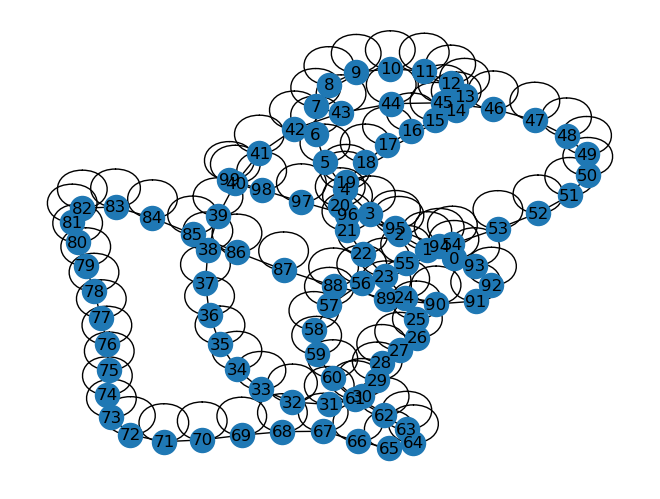

Run time for Our Algorithm: 10.711312055587769
Run time for Direct: 3.4226109981536865


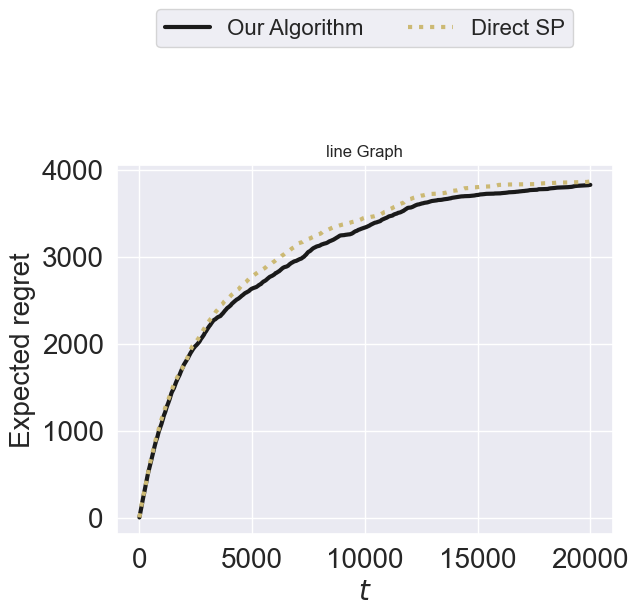

Total run time: 14.641465187072754


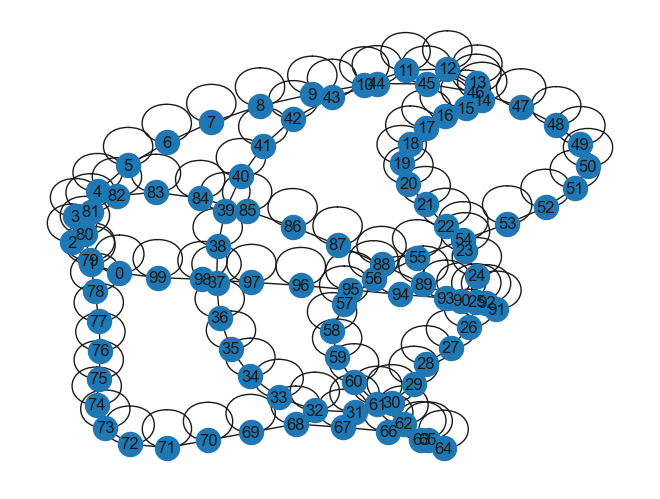

Run time for Our Algorithm: 10.498925924301147
Run time for Direct: 3.672337055206299


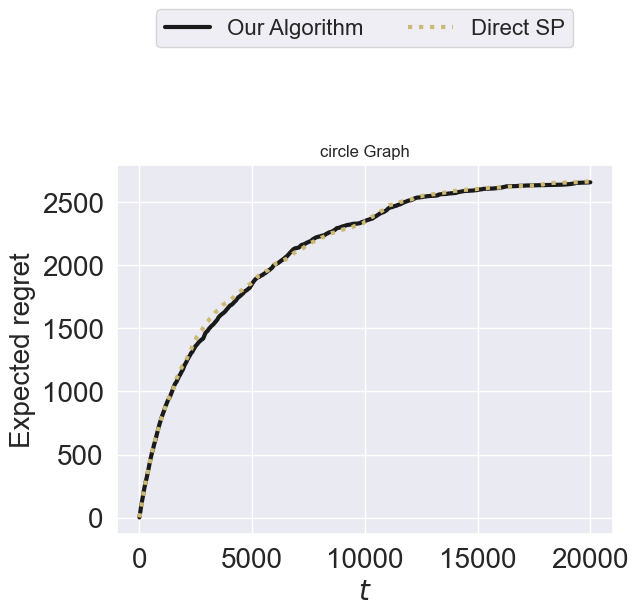

Total run time: 14.340094089508057


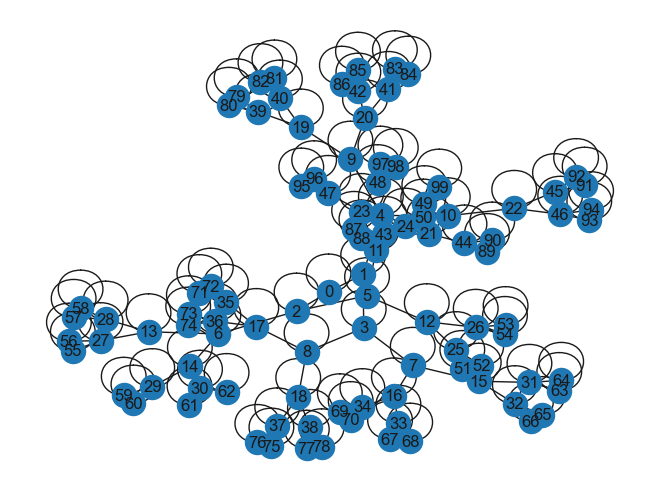

Run time for Our Algorithm: 5.9047276973724365
Run time for Direct: 3.959268093109131


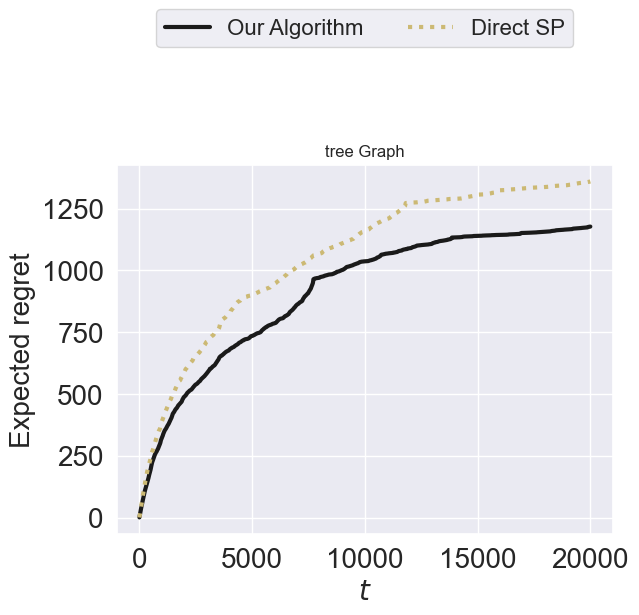

Total run time: 10.029654026031494


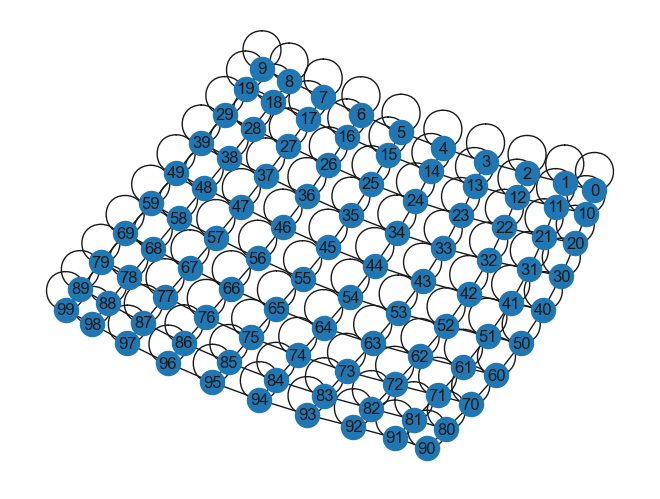

Run time for Our Algorithm: 6.779029130935669
Run time for Direct: 2.8070590496063232


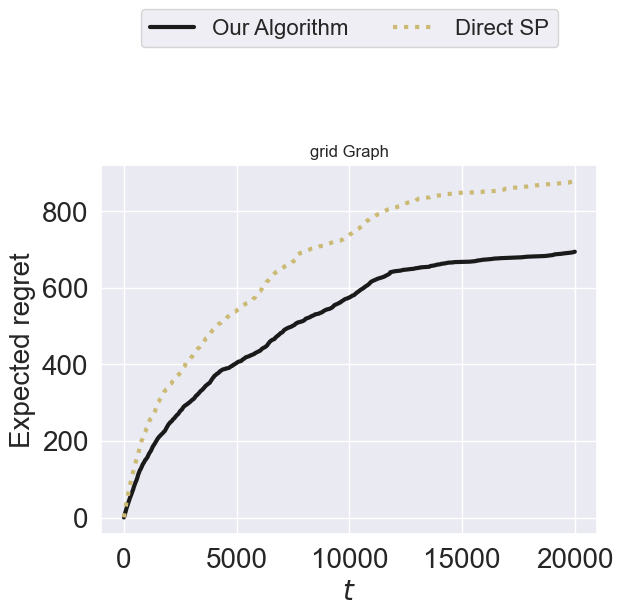

Total run time: 9.708849906921387


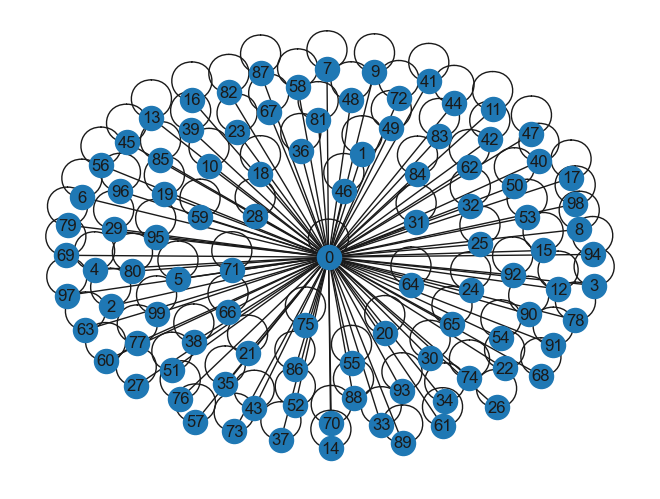

Run time for Our Algorithm: 4.110034942626953
Run time for Direct: 3.495075225830078


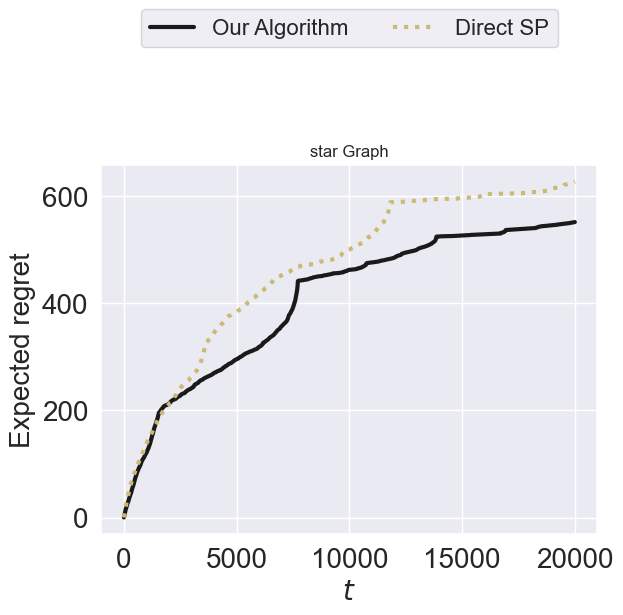

Total run time: 7.79705286026001


In [6]:
graph_types = ['line','circle','tree','grid','star']
n_samples = 100
init_node = 0
T = 20000
n_nodes = 100

for graph in graph_types:
    np.random.seed(SEED)
    G = return_graph(graph, n_nodes)
    draw_graph(G)

    np.random.seed(SEED)
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    agents = {
         'Our Algorithm':GUCB_agent,
        'Direct': direct_agent
}

    t0 = time()
    line_regrets = {}
    for name,agent in agents.items():
        t = time()
        line_regrets[name] = train_agent(n_samples,T,G,means, init_node,agent,parallelized=True)
        print('Run time for {}:'.format(name),time()-t)


    with open('Data/{}_direct.pkl'.format(graph), 'wb') as file:
        pkl.dump(line_regrets,file)

    plt.figure(dpi=100)

    plotRegrets([line_regrets], titles=['{} Graph'.format(graph)])
    print('Total run time:', time()-t0)